In [1]:
import json

js15 = json.load(open('dataset/socrata_metadata_2015-building-energy-benchmarking.json', mode='r'))
js16 = json.load(open('dataset/socrata_metadata_2016-building-energy-benchmarking.json', mode='r'))

In [2]:
import matplotlib.pyplot as plt
import os
import missingno as msno
import numpy as np
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

## Merge two datasets


In [3]:
df15 = pd.read_csv('dataset/2015-building-energy-benchmarking.csv')
df16 = pd.read_csv('dataset/2016-building-energy-benchmarking.csv')

In [4]:
print(df15.shape)
print(df15.columns)

(3340, 47)
Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'Location',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'Defa

In [5]:
print(df16.shape)
print(df16.columns)

(3376, 46)
Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
    

In [6]:
# montrer les differences de colonnes entre les dataset

contained16in15 = [col in df16.columns for col in df15.columns ]
extra15 = df15.columns[np.invert(contained16in15)]
print(extra15)

# describe to what corresponds the extra columns
for col in extra15:
	print(col, ' : ', next(item for item in js15['columns'] if item['name'] == col).get('description'))


Index(['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats', 'Zip Codes'],
      dtype='object')
Location  :  None
OtherFuelUse(kBtu)  :  None
GHGEmissions(MetricTonsCO2e)  :  The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu. 
GHGEmissionsIntensity(kgCO2e/ft2)  :  	
Total Greenhouse Gas Emissions divided by 

In [7]:
contained15in16 = [col in df15.columns for col in df16.columns ]
extra16 = df16.columns[np.invert(contained15in16)]
print(extra16)

# describe to what corresponds the extra columns
for col in extra16:
	print(col, ' : ', next(item for item in js16['columns'] if item['name'] == col).get('description'))


Index(['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude',
       'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')
Address  :  Property street address
City  :  Property city
State  :  Property state
ZipCode  :  Property zip
Latitude  :  Property latitude.
Longitude  :  Property longitude.
Comments  :  Comments by a building owner or agent to provide context to the building’s energy use.  
TotalGHGEmissions  :  The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Man

In [8]:
# examples of Location
print(df15.loc[0, 'Location'])
print(df16.loc[0, ['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude']])
# df15 has location in one single row
# whereas df1516 has one column for each data
# let's split !


{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
Address      405 Olive way
City               Seattle
State                   WA
ZipCode            98101.0
Latitude           47.6122
Longitude       -122.33799
Name: 0, dtype: object


In [9]:
import ast
		
# split Location column
for index, row in df15.iterrows():
	l = ast.literal_eval(df15.loc[index, 'Location'])
	addr = ast.literal_eval(l['human_address'])
	df15.loc[index, 'Latitude'] = l['latitude']
	df15.loc[index, 'Longitude'] = l['longitude']
	df15.loc[index, 'Address'] = addr['address']
	df15.loc[index, 'City'] = addr['city']
	df15.loc[index, 'State'] = addr['state']
	df15.loc[index, 'ZipCode'] = addr['zip']


# convert to correct type as ast convert to str
df15=df15.astype({'Latitude' : 'float64', 'Longitude' : 'float64', 'ZipCode' : 'float64'})


In [10]:
print(df16['TotalGHGEmissions'].describe())
print(df15['GHGEmissions(MetricTonsCO2e)'].describe())

count     3367.000000
mean       119.723971
std        538.832227
min         -0.800000
25%          9.495000
50%         33.920000
75%         93.940000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64
count     3330.000000
mean       110.094102
std        409.450179
min          0.000000
25%          9.265000
50%         32.740000
75%         88.642500
max      11824.890000
Name: GHGEmissions(MetricTonsCO2e), dtype: float64


In [11]:
print(df16['GHGEmissionsIntensity'].describe())
print(df15['GHGEmissionsIntensity(kgCO2e/ft2)'].describe())

count    3367.000000
mean        1.175916
std         1.821452
min        -0.020000
25%         0.210000
50%         0.610000
75%         1.370000
max        34.090000
Name: GHGEmissionsIntensity, dtype: float64
count    3330.000000
mean        0.985339
std         1.637172
min         0.000000
25%         0.080000
50%         0.460000
75%         1.180000
max        31.380000
Name: GHGEmissionsIntensity(kgCO2e/ft2), dtype: float64


In [12]:

# columns from df15 and df16 are on the same scale, so they can be merged as is in the resulting dataset
# copy identical columns then will drop all
df15['TotalGHGEmissions'] = df15['GHGEmissions(MetricTonsCO2e)']
df15['GHGEmissionsIntensity'] = df15['GHGEmissionsIntensity(kgCO2e/ft2)']

df15.drop(extra15, axis=1, inplace=True)
df16.drop('Comments', axis=1, inplace=True)


In [13]:
# merge common columns
df = pd.merge(df15, df16, how='outer')
print(df15.shape, df16.shape, df.shape)



(3340, 45) (3376, 45) (6716, 45)


In [14]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,...,Compliant,NaN,47.612190,-122.337997,405 OLIVE WAY,SEATTLE,WA,98101.0,249.43,2.64
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,...,Compliant,NaN,47.613106,-122.333358,724 PINE ST,SEATTLE,WA,98101.0,263.51,2.38
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.0,...,Compliant,NaN,47.613349,-122.337699,1900 5TH AVE,SEATTLE,WA,98101.0,2061.48,1.92
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1.0,...,Compliant,High Outlier,47.614216,-122.336609,620 STEWART ST,SEATTLE,WA,98101.0,1936.34,31.38
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1.0,...,Compliant,NaN,47.613754,-122.340924,401 LENORA ST,SEATTLE,WA,98121.0,507.70,4.02


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 6715
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6716 non-null   int64  
 1   DataYear                         6716 non-null   int64  
 2   BuildingType                     6716 non-null   object 
 3   PrimaryPropertyType              6716 non-null   object 
 4   PropertyName                     6716 non-null   object 
 5   TaxParcelIdentificationNumber    6714 non-null   object 
 6   CouncilDistrictCode              6716 non-null   int64  
 7   Neighborhood                     6716 non-null   object 
 8   YearBuilt                        6716 non-null   int64  
 9   NumberofBuildings                6708 non-null   float64
 10  NumberofFloors                   6708 non-null   float64
 11  PropertyGFATotal                 6716 non-null   int64  
 12  PropertyGFAParking  

In [16]:
# Just for fun, display the points on a map
import folium
from folium.plugins import MarkerCluster

m = folium.Map(location=[df.loc[0, 'Latitude'], df.loc[0, 'Longitude']], zoom_start=13)
marker_cluster = MarkerCluster().add_to(m)

for index, row in df.iterrows():
	folium.Marker([row['Latitude'], row['Longitude']]).add_to(marker_cluster)

m

## Data Cleaning and Features Engineering

<AxesSubplot:ylabel='None'>

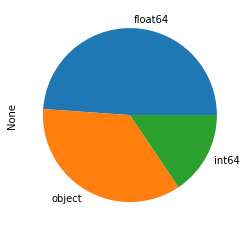

In [17]:
df.dtypes.value_counts().plot.pie()

### Empty Features analysis

<AxesSubplot:>

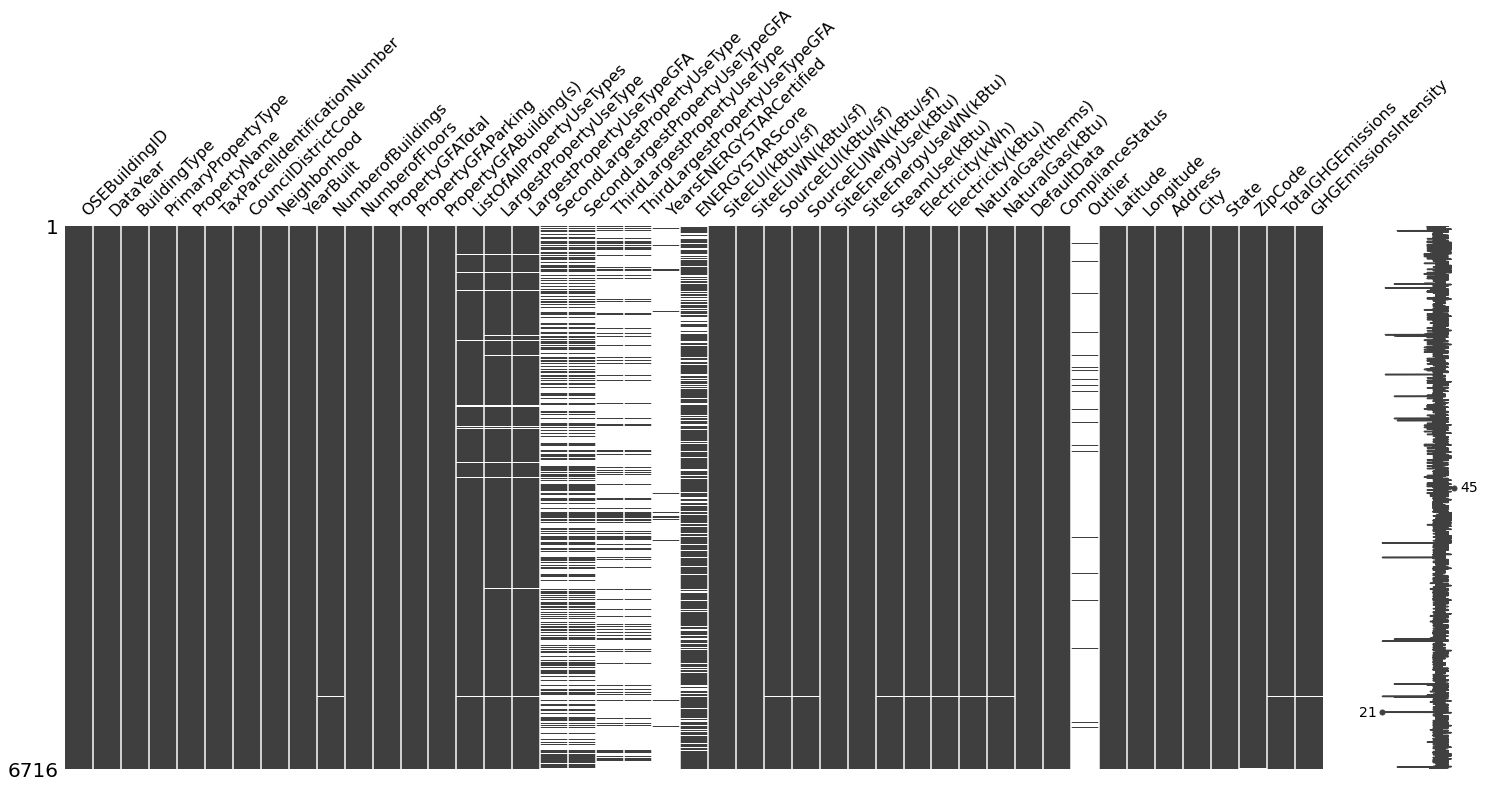

In [18]:
import missingno as msno
msno.matrix(df)

<AxesSubplot:ylabel='Frequency'>

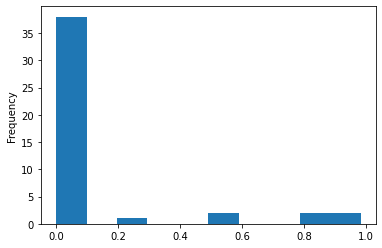

In [19]:
# show columns with (too much) empty values
df.isna().mean().sort_values().plot(kind="hist")

In [20]:
threshold = 0.5
for col in df.columns:
	if df[col].isna().mean() > threshold:
		print('removing empty column: ', col)
		df.drop(col, axis=1, inplace=True)


removing empty column:  SecondLargestPropertyUseType
removing empty column:  SecondLargestPropertyUseTypeGFA
removing empty column:  ThirdLargestPropertyUseType
removing empty column:  ThirdLargestPropertyUseTypeGFA
removing empty column:  YearsENERGYSTARCertified
removing empty column:  Outlier


### Outliers Analysis

In [21]:
def dropOutlierIQR(df, col):
    Q1 = df[col].quantile(0.25)
    # print(Q1)
    Q3 = df[col].quantile(0.75)
    # print(Q3)
    IQR = Q3 - Q1
    # print(IQR)
    df[col] = df[col][df[col].between((Q1 - 1.5 * IQR), (Q3 + 1.5 * IQR))]

In [22]:
for col in df.select_dtypes('float').columns:
	dropOutlierIQR(df, col)

In [23]:
for col in df.select_dtypes('int').columns:
	dropOutlierIQR(df, col)

<AxesSubplot:>

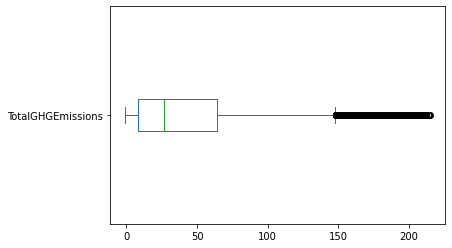

In [24]:
df.TotalGHGEmissions.plot(kind='box', vert= False)

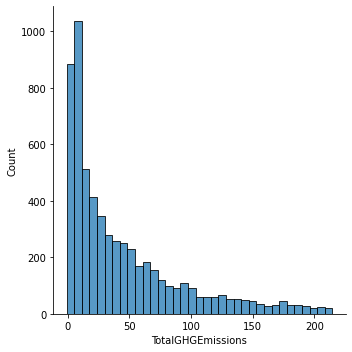

In [25]:
sns.displot(df.TotalGHGEmissions)

<AxesSubplot:>

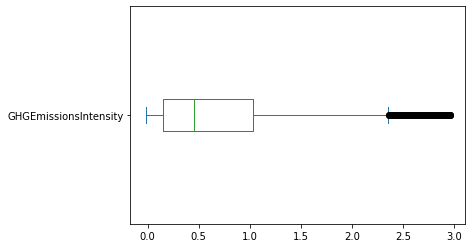

In [26]:
df.GHGEmissionsIntensity.plot(kind='box', vert= False)

<AxesSubplot:xlabel='GHGEmissionsIntensity', ylabel='Density'>

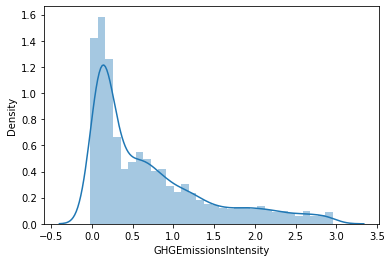

In [27]:
sns.distplot(df.GHGEmissionsIntensity)

### Features Correlations Analysis

In [28]:
# features correlations
def show_feat_correlations(df):
	correlations = np.abs(df.select_dtypes('float').corr(method="pearson"))

	mask = np.zeros_like(correlations)
	mask[np.triu_indices_from(mask)] = True
	sns.axes_style("white")
	plt.subplots(figsize=(20,20))
	sns.heatmap(correlations, mask=mask, vmax=1, square=True, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True, cmap='cividis')

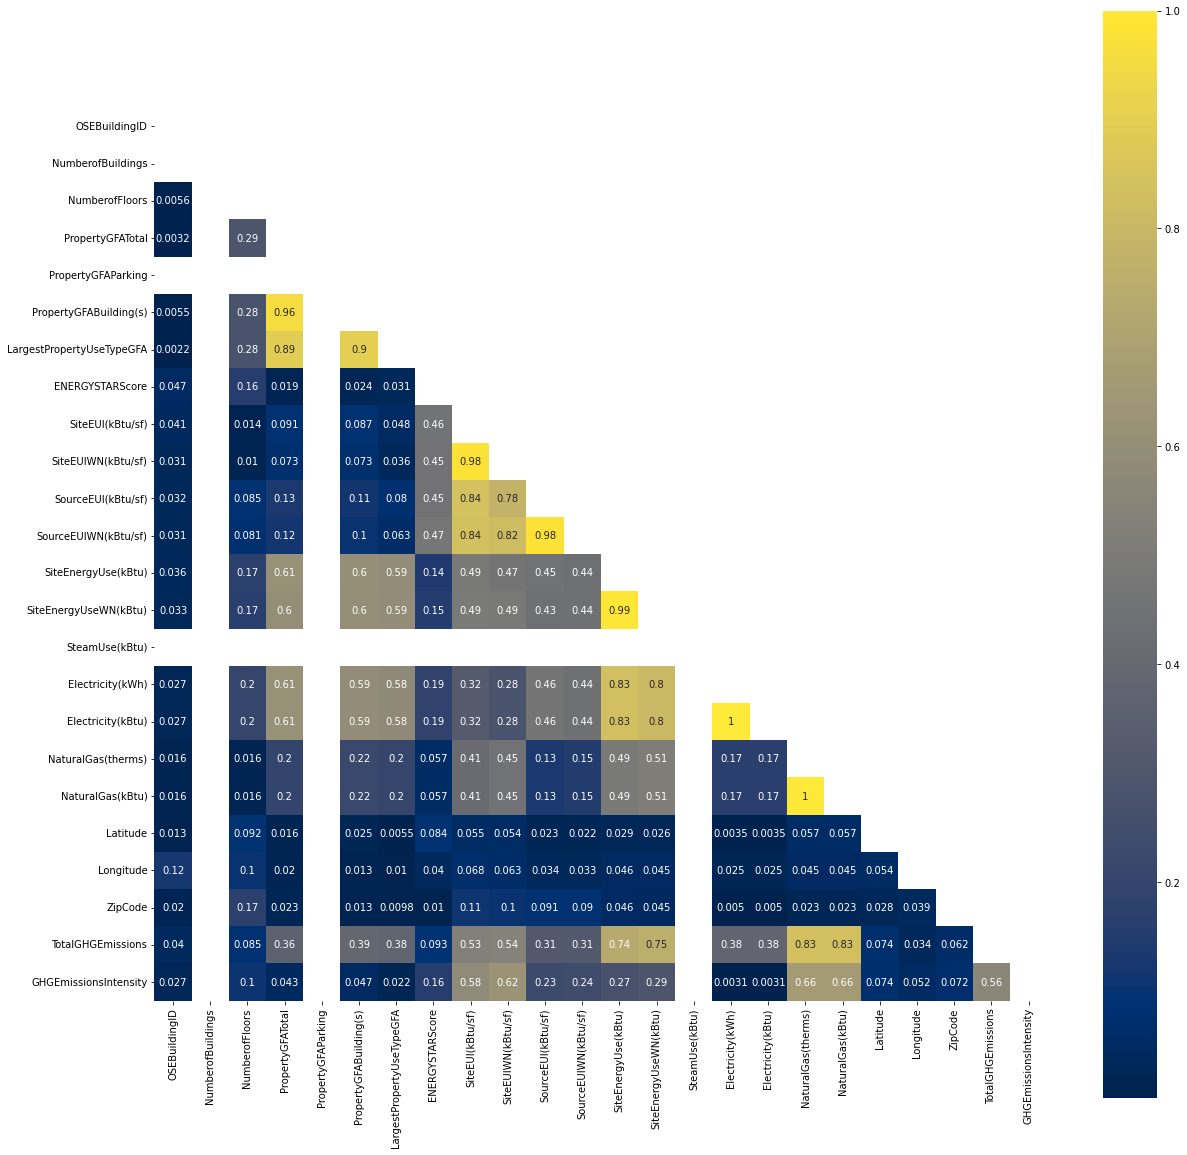

In [29]:
show_feat_correlations(df)

In [30]:
# don't need this feature, since duplicates the one with kBtu
df.drop('Electricity(kWh)', axis=1, inplace=True)

# also, we don't need the features 'WN', they are highly correlated with their siblings 'without WN'
colsWN = []
for col in df.columns:
	if 'WN' in col:
		colsWN.append(col)
df.drop(colsWN, axis=1, inplace=True)

# lastly, we can remove NaturalGas(therms), since it the same than naturalGas(kBtu), only the unit change
df.drop('NaturalGas(therms)', axis=1, inplace=True)

# State has unique value
df.drop('State', axis=1, inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 6715
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  4985 non-null   float64
 1   DataYear                       6716 non-null   int64  
 2   BuildingType                   6716 non-null   object 
 3   PrimaryPropertyType            6716 non-null   object 
 4   PropertyName                   6716 non-null   object 
 5   TaxParcelIdentificationNumber  6714 non-null   object 
 6   CouncilDistrictCode            6716 non-null   int64  
 7   Neighborhood                   6716 non-null   object 
 8   YearBuilt                      6716 non-null   int64  
 9   NumberofBuildings              6496 non-null   float64
 10  NumberofFloors                 6236 non-null   float64
 11  PropertyGFATotal               5977 non-null   float64
 12  PropertyGFAParking             5288 non-null   f

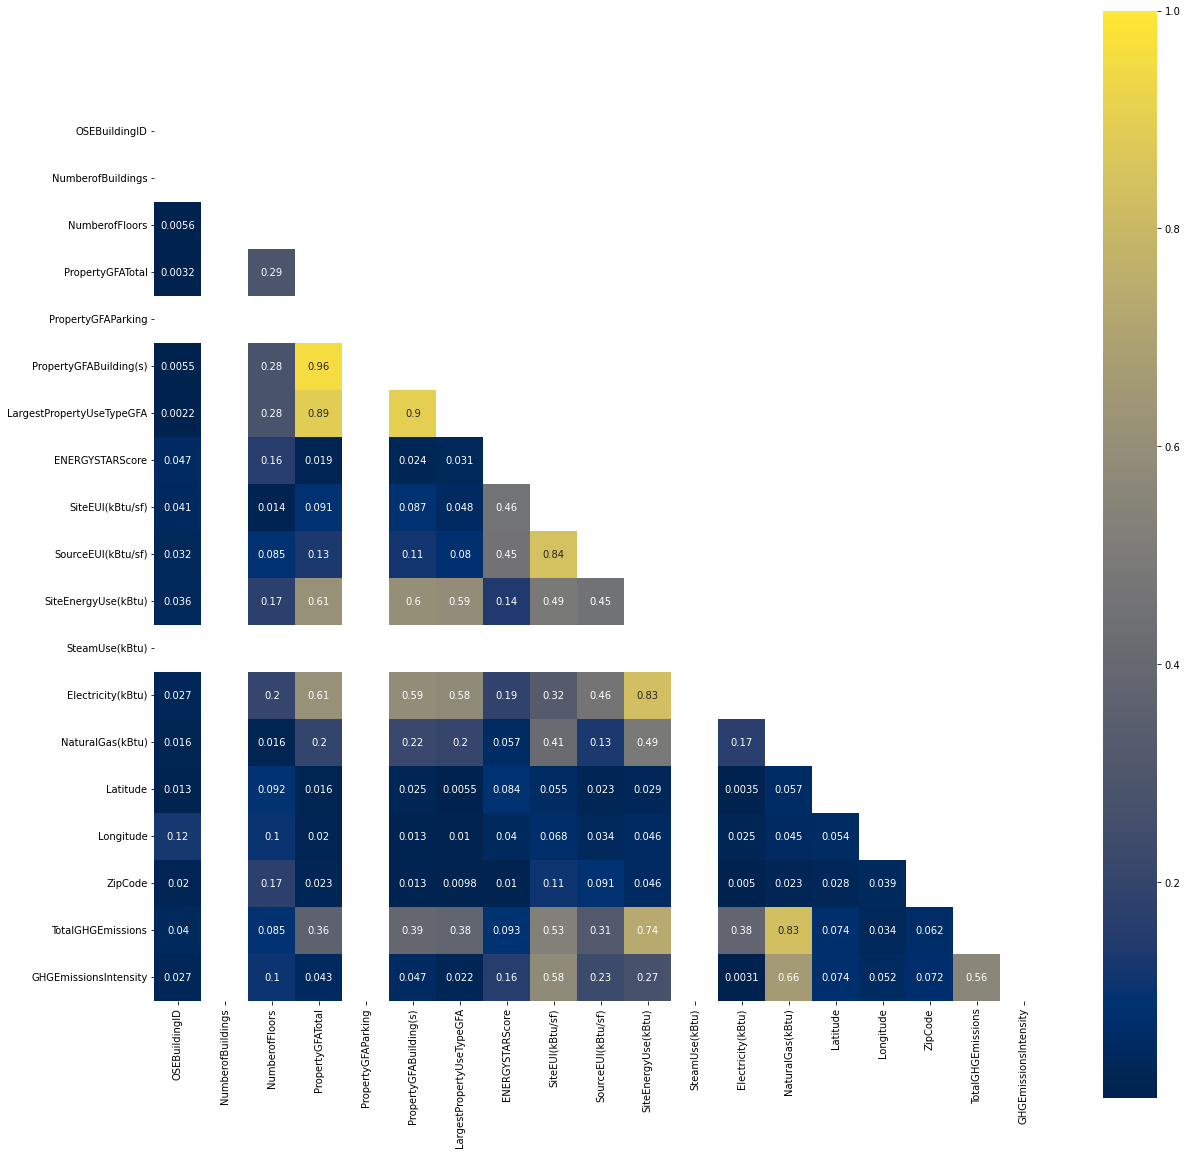

In [32]:
show_feat_correlations(df)

<AxesSubplot:ylabel='None'>

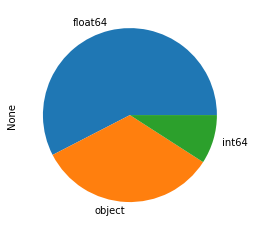

In [33]:
df.dtypes.value_counts().plot.pie()

## Features Analysis

### Ints

In [34]:
df.select_dtypes('int')

,DataYear,CouncilDistrictCode,YearBuilt
0,2015,7,1927
1,2015,7,1996
2,2015,7,1969
3,2015,7,1926
4,2015,7,1980
...,...,...,...
6711,2016,2,1990
6712,2016,2,2004
6713,2016,7,1974
6714,2016,1,1989


In [35]:
# feature engineering : we create an age od the building, more convenient than year of build
df['BuildingAge'] = df.DataYear - df.YearBuilt

In [36]:
df.select_dtypes('int').columns


Index(['DataYear', 'CouncilDistrictCode', 'YearBuilt', 'BuildingAge'], dtype='object')

In [37]:

# except BuildingAge, none of the other features are very interesting, we could drop them
df.drop(['YearBuilt', 'CouncilDistrictCode', 'DataYear'], axis=1, inplace=True)

<AxesSubplot:>

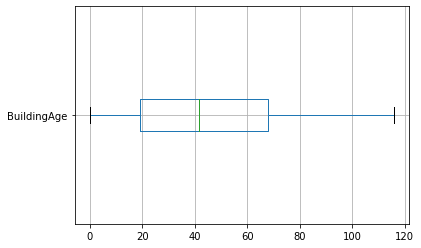

In [38]:

df.select_dtypes('int').boxplot(vert=False)

### Objects

In [39]:
df.select_dtypes('object')

,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,DefaultData,ComplianceStatus,Address,City
0,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,DOWNTOWN,Hotel,Hotel,No,Compliant,405 OLIVE WAY,SEATTLE
1,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,DOWNTOWN,"Hotel, Parking, Restaurant",Hotel,No,Compliant,724 PINE ST,SEATTLE
2,NonResidential,Hotel,WESTIN HOTEL,659000475,DOWNTOWN,"Hotel, Parking, Swimming Pool",Hotel,Yes,Compliant,1900 5TH AVE,SEATTLE
3,NonResidential,Hotel,HOTEL MAX,659000640,DOWNTOWN,Hotel,Hotel,No,Compliant,620 STEWART ST,SEATTLE
4,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,DOWNTOWN,"Hotel, Parking, Swimming Pool",Hotel,No,Compliant,401 LENORA ST,SEATTLE
...,...,...,...,...,...,...,...,...,...,...,...
6711,Nonresidential COS,Office,Horticulture building,1624049080,GREATER DUWAMISH,Office,Office,True,Error - Correct Default Data,1600 S Dakota St,Seattle
6712,Nonresidential COS,Other,International district/Chinatown CC,3558300000,DOWNTOWN,Other - Recreation,Other - Recreation,False,Compliant,719 8th Ave S,Seattle
6713,Nonresidential COS,Other,Queen Anne Pool,1794501150,MAGNOLIA / QUEEN ANNE,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,False,Compliant,1920 1st Ave W,Seattle
6714,Nonresidential COS,Mixed Use Property,South Park Community Center,7883603155,GREATER DUWAMISH,"Fitness Center/Health Club/Gym, Food Service, ...",Other - Recreation,False,Compliant,8319 8th Ave S,Seattle


In [40]:
df.select_dtypes('object').nunique()

BuildingType                        8
PrimaryPropertyType                32
PropertyName                     6527
TaxParcelIdentificationNumber    3729
Neighborhood                       19
ListOfAllPropertyUseTypes         488
LargestPropertyUseType             57
DefaultData                         4
ComplianceStatus                    5
Address                          6379
City                                2
dtype: int64

In [41]:
# Some features are not interesting, we can remove them
df.drop(['PropertyName', 'Address', 'City', 'DefaultData'], axis=1, inplace=True)

count                     6716
unique                      32
top       Low-Rise Multifamily
freq                      1985
Name: PrimaryPropertyType, dtype: object


<AxesSubplot:>

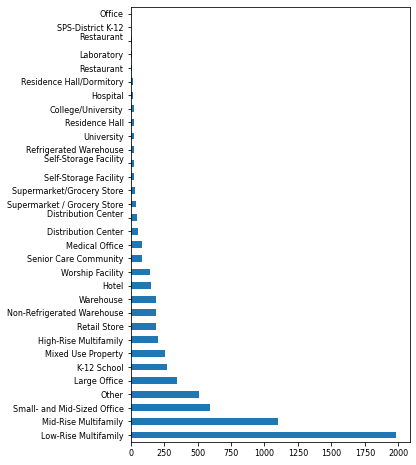

In [42]:
print(df.PrimaryPropertyType.describe())

plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(5,8))
df.PrimaryPropertyType.value_counts().plot(kind='barh')

In [43]:
print(df.ListOfAllPropertyUseTypes.describe())
df.ListOfAllPropertyUseTypes.head()
# this feature is a concatenation of several values, seperated by ', '
# we could try to seperate them, but in fact this feature is not very intersting, since there is feature 'LargestPropertyUseType', that we'll use instead

df.drop('ListOfAllPropertyUseTypes', axis=1, inplace=True)


count                    6580
unique                    488
top       Multifamily Housing
freq                     1728
Name: ListOfAllPropertyUseTypes, dtype: object


<AxesSubplot:>

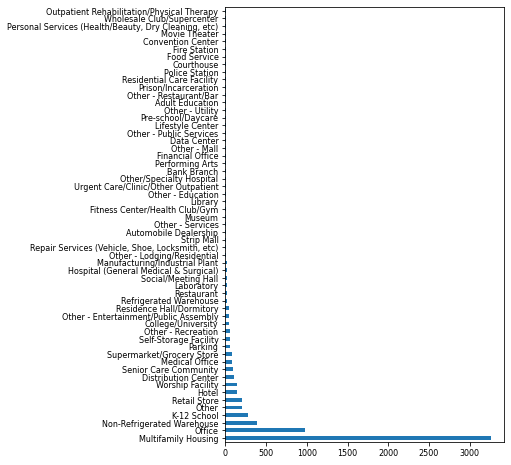

In [44]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(5,8))
df.LargestPropertyUseType.value_counts().plot(kind='barh')

<AxesSubplot:>

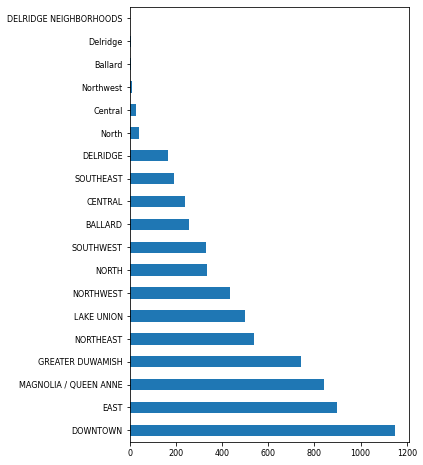

In [45]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(5,8))
df.Neighborhood.value_counts().plot(kind='barh')


In [46]:
df.ComplianceStatus.describe()

count          6716
unique            5
top       Compliant
freq           6548
Name: ComplianceStatus, dtype: object

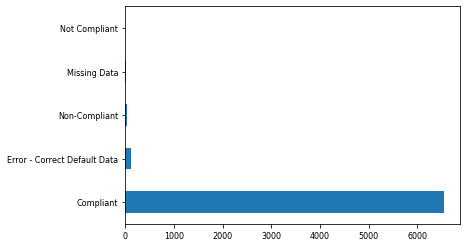

In [47]:
df.ComplianceStatus.value_counts().plot.barh()
# most of the values are compliant, we could remove the ones which are not (they may be misleading our predictions since the energy consumption is not accurate)
df = df[df.ComplianceStatus == 'Compliant']
df.drop(['ComplianceStatus'], axis=1, inplace=True)

In [48]:
df.shape

(6548, 25)

### Floats


In [49]:
df.select_dtypes('float')

,OSEBuildingID,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Latitude,Longitude,ZipCode,TotalGHGEmissions,GHGEmissionsIntensity
0,NaN,1.0,NaN,88434.0,0.0,88434.0,88434.0,65.0,78.900000,173.500000,6.981428e+06,NaN,3.686160e+06,1.272388e+06,47.612190,-122.337997,98101.0,NaN,2.64
1,NaN,1.0,NaN,103566.0,NaN,88502.0,83880.0,51.0,94.400000,191.300000,8.354235e+06,0.0,3.905411e+06,NaN,47.613106,-122.333358,98101.0,NaN,2.38
2,NaN,1.0,NaN,NaN,0.0,NaN,NaN,18.0,96.600000,242.700000,NaN,NaN,NaN,NaN,47.613349,-122.337699,98101.0,NaN,1.92
3,NaN,1.0,NaN,61320.0,0.0,61320.0,61320.0,1.0,NaN,NaN,NaN,NaN,2.769023e+06,2.001894e+06,47.614216,-122.336609,98101.0,NaN,NaN
4,NaN,1.0,NaN,119890.0,NaN,107430.0,123445.0,67.0,NaN,228.800000,NaN,0.0,NaN,NaN,47.613754,-122.340924,98121.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6710,NaN,1.0,1.0,18261.0,0.0,18261.0,18261.0,NaN,51.000000,126.000000,9.320821e+05,0.0,6.323620e+05,2.997200e+05,47.540670,-122.374410,NaN,20.33,1.11
6712,NaN,1.0,1.0,16000.0,0.0,16000.0,16000.0,NaN,59.400002,114.199997,9.502762e+05,0.0,3.965461e+05,5.537300e+05,47.596250,-122.322830,NaN,32.17,2.01
6713,NaN,1.0,1.0,13157.0,0.0,13157.0,7583.0,NaN,NaN,NaN,5.765898e+06,0.0,1.792159e+06,NaN,47.636440,-122.357840,NaN,NaN,NaN
6714,NaN,1.0,1.0,14101.0,0.0,14101.0,6601.0,NaN,51.000000,105.300003,7.194712e+05,0.0,3.488702e+05,3.706010e+05,47.528320,-122.324310,NaN,22.11,1.57


#### Location

In [50]:
from geopy.distance import distance

df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

# official position of Seattle (https://www.latlong.net/place/seattle-wa-usa-2655.html)
d0 = (47.608013, -122.335167)
points = zip(df.Latitude, df.Longitude)
# for p in points:
# 	print(p)
df['Distance'] = [distance(d0, point).miles for point in zip(df.Latitude, df.Longitude)]


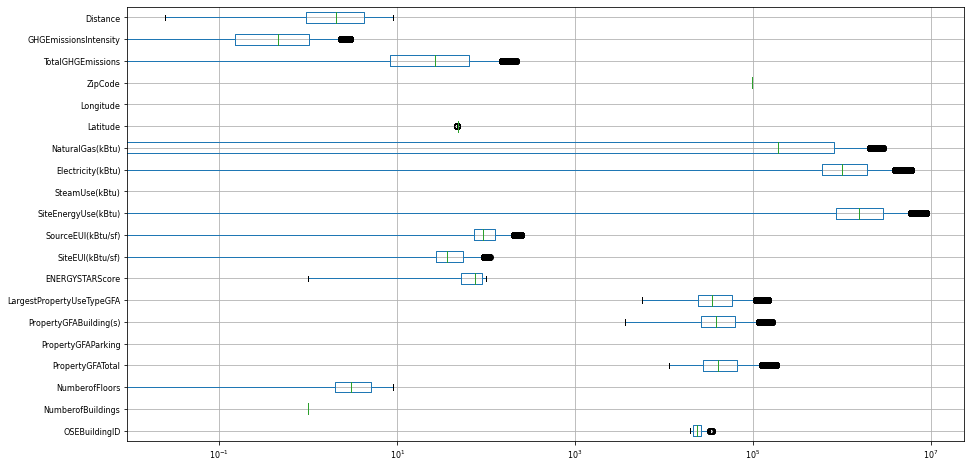

In [51]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(15,8))
df.select_dtypes('float').boxplot(vert=False)
plt.xscale('log')


In [52]:

# some features are not interesting, we could drop them
df.drop(['ZipCode', 'OSEBuildingID', 'SteamUse(kBtu)', 'PropertyGFAParking', 'NumberofBuildings'], axis=1, inplace=True)

In [53]:
# remove some NaN values,
df.dropna(subset=['TotalGHGEmissions'], inplace=True)
df.shape

(5637, 21)

In [54]:
df.select_dtypes('float')

,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Latitude,Longitude,TotalGHGEmissions,GHGEmissionsIntensity,Distance
6,NaN,83008.0,83008.0,81352.0,25.0,76.900000,149.500000,6.252842e+06,2.679698e+06,NaN,47.614114,-122.332741,208.46,2.37,0.436472
7,8.0,102761.0,102761.0,102761.0,NaN,62.500000,152.200000,6.426022e+06,4.108004e+06,3.150790e+05,47.612902,-122.331309,199.99,1.77,0.382852
9,6.0,63712.0,62216.0,56132.0,2.0,81.700000,178.100000,4.587231e+06,2.370050e+06,7.338030e+05,47.602784,-122.332149,170.00,2.51,0.387786
15,NaN,NaN,NaN,NaN,NaN,46.000000,140.800000,NaN,NaN,0.000000e+00,47.606675,-122.332264,166.84,0.24,0.164125
23,6.0,88592.0,58006.0,58006.0,85.0,66.900000,151.500000,3.880806e+06,2.254751e+06,1.626149e+06,47.659533,-122.317392,102.08,1.04,3.654798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6708,1.0,20050.0,20050.0,8108.0,NaN,90.400002,175.199997,1.813404e+06,7.694531e+05,1.043951e+06,47.607750,-122.302250,60.81,NaN,1.538001
6710,1.0,18261.0,18261.0,18261.0,NaN,51.000000,126.000000,9.320821e+05,6.323620e+05,2.997200e+05,47.540670,-122.374410,20.33,1.11,5.001076
6712,1.0,16000.0,16000.0,16000.0,NaN,59.400002,114.199997,9.502762e+05,3.965461e+05,5.537300e+05,47.596250,-122.322830,32.17,2.01,0.996345
6714,1.0,14101.0,14101.0,6601.0,NaN,51.000000,105.300003,7.194712e+05,3.488702e+05,3.706010e+05,47.528320,-122.324310,22.11,1.57,5.528963


In [55]:
for col in df.select_dtypes('float'):
	print(f'{col} contains {df[col].isna().sum()} Nan values')

NumberofFloors contains 233 Nan values
PropertyGFATotal contains 349 Nan values
PropertyGFABuilding(s) contains 302 Nan values
LargestPropertyUseTypeGFA contains 428 Nan values
ENERGYSTARScore contains 1321 Nan values
SiteEUI(kBtu/sf) contains 217 Nan values
SourceEUI(kBtu/sf) contains 320 Nan values
SiteEnergyUse(kBtu) contains 204 Nan values
Electricity(kBtu) contains 331 Nan values
NaturalGas(kBtu) contains 116 Nan values
Latitude contains 0 Nan values
Longitude contains 0 Nan values
TotalGHGEmissions contains 0 Nan values
GHGEmissionsIntensity contains 265 Nan values
Distance contains 0 Nan values


In [56]:
# TODO WIP
# replace NaN values for some features
# example for NumberofFloors --> 0 by default. we consider a building has at least one floor (groundfloor UK ), it's a value that exists and thus is valid
df['NumberofFloors'] = df['NumberofFloors'].fillna(0)

# df['SiteEUI(kBtu/sf)'] = df['SiteEUI(kBtu/sf)'].fillna(0)
# df['SourceEUI(kBtu/sf)'] = df['SourceEUI(kBtu/sf)'].fillna(0)
# df['SiteEnergyUse(kBtu)'] = df['SiteEnergyUse(kBtu)'].fillna(0)


In [57]:
# TODO WIP
df.dropna(subset=df.select_dtypes('float').columns.values, inplace=True)
df.shape

(3508, 21)

In [58]:
df.to_pickle("./tmp/df_cleaned.gzip")

## Multivariate Analysis

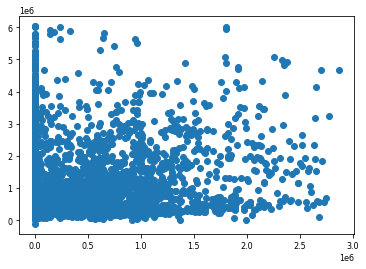

In [59]:
plt.scatter(df['NaturalGas(kBtu)'], df['Electricity(kBtu)'])

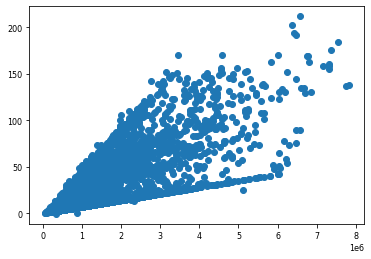

In [60]:
plt.scatter(df['SiteEnergyUse(kBtu)'], df.TotalGHGEmissions)

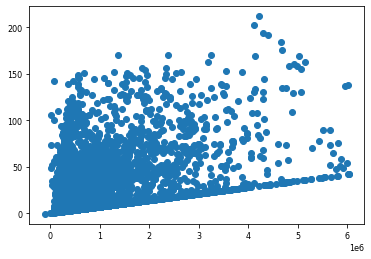

In [61]:
plt.scatter(df['Electricity(kBtu)'], df.TotalGHGEmissions)

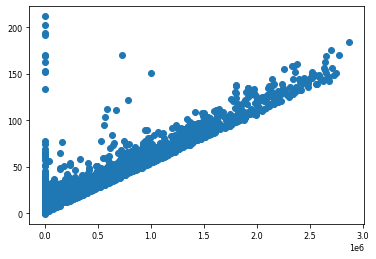

In [62]:
plt.scatter(df['NaturalGas(kBtu)'], df.TotalGHGEmissions)

<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Neighborhood'>

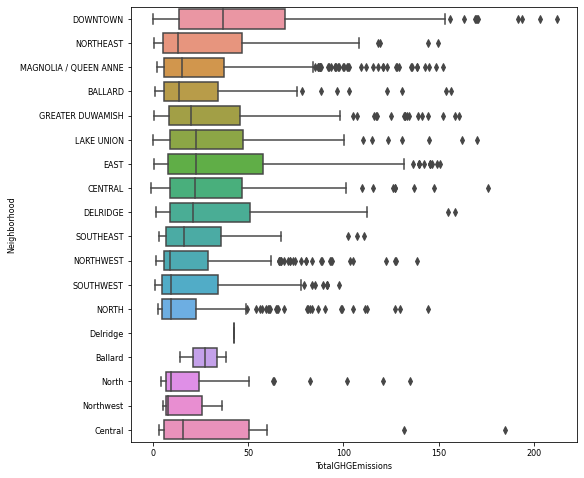

In [63]:
plt.figure(figsize=(8,8))
sns.boxplot(x='TotalGHGEmissions', y='Neighborhood', data=df)

<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='LargestPropertyUseType'>

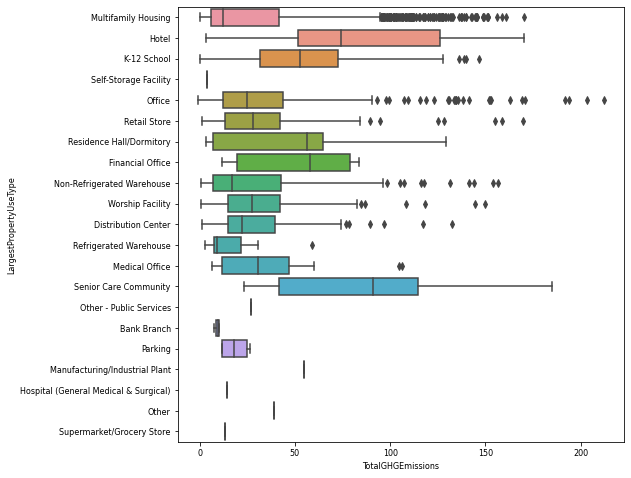

In [64]:
plt.figure(figsize=(8,8))
sns.boxplot(x='TotalGHGEmissions', y='LargestPropertyUseType', data=df)

<AxesSubplot:xlabel='BuildingAge', ylabel='TotalGHGEmissions'>

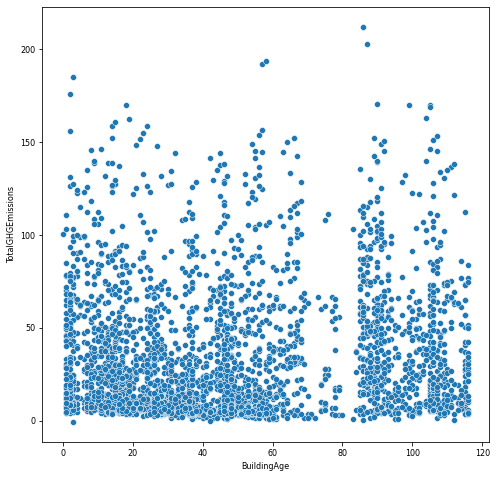

In [65]:
plt.figure(figsize=(8,8))
sns.scatterplot(y='TotalGHGEmissions', x='BuildingAge', data=df)

<AxesSubplot:xlabel='Distance', ylabel='SiteEnergyUse(kBtu)'>

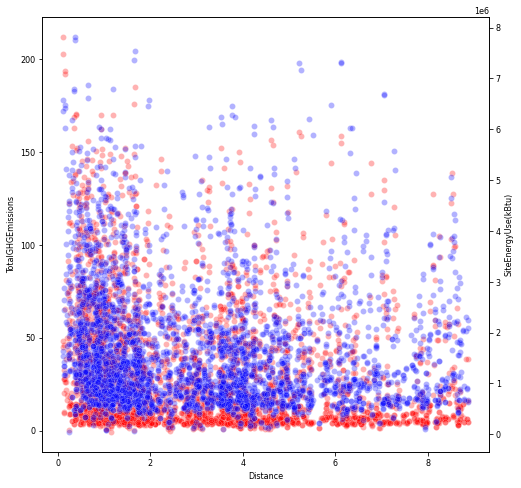

In [66]:
fig, ax1 = plt.subplots(figsize=(8,8))
ax2 = ax1.twinx()
sns.scatterplot(y='TotalGHGEmissions', x='Distance', data=df, ax=ax1, color='red', alpha=0.3)
sns.scatterplot(y='SiteEnergyUse(kBtu)', x='Distance', data=df, ax=ax2, color='blue', alpha=0.3)
# seems the farther we are from the center, the less we consumme and polute ?